In [59]:
# importing packages
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from numpy.linalg import cond, matrix_rank, norm
from scipy.linalg import inv, solve, det, eig, lu, eigvals
from sklearn.metrics import confusion_matrix
import statsmodels.api as sm
from statsmodels.tsa.vector_ar.svar_model import SVAR
import warnings
warnings.filterwarnings("ignore")

In [60]:
#importing data
BL = pd.read_csv('Data/BankLend.csv')
consumption = pd.read_csv('Data/consumption 2.csv')
gdp_exp = pd.read_csv('Data/gdp.csv')
housing_starts = pd.read_csv('Data/HousingStarts.csv')
ex_rate = pd.read_csv('Data/CEER_MONTHLY_NOMINAL-sd-1990-01-01.csv') #Canadian Effective Exchange Rate - monthly nominal
SP_tbills = pd.read_csv('Data/s&p, tbills.csv')
house_prices = pd.read_csv('Data/OECD Data.csv')

In [61]:
# BANK LENDING

# Summing over rows of 3 to get quarterly data
def sum_quarter(group):
    return pd.Series({'ReferencePeriod': group['ReferencePeriod'].iloc[0],
                      'Total, funds advanced, residential mortgages, insured 7': group['Total, funds advanced, residential mortgages, insured 7'].sum(),
                      'Total, funds advanced, residential mortgages, uninsured 7': group['Total, funds advanced, residential mortgages, uninsured 7'].sum(),
                      'Total, funds advanced, variable rate mortgages': group['Total, funds advanced, variable rate mortgages'].sum(),
                      'Total, funds advanced for non-mortgage loans, consumer credit': group['Total, funds advanced for non-mortgage loans, consumer credit'].sum(),
                      'Total, funds advanced, business loans 8': group['Total, funds advanced, business loans 8'].sum()})

# Group by sets of 3 rows and average using the custom function
BankLend = BL.groupby(BL.index // 3).apply(sum_quarter)
BankLend['ReferencePeriod'] = pd.to_datetime(BankLend['ReferencePeriod'])
BankLend['Quarters'] = BankLend['ReferencePeriod'].dt.to_period("Q").astype(str)

# cleaning up the data
BankLend['BankLending'] = BankLend['Total, funds advanced, residential mortgages, insured 7'] + BankLend['Total, funds advanced, residential mortgages, uninsured 7'] +  BankLend['Total, funds advanced, variable rate mortgages'] + BankLend['Total, funds advanced for non-mortgage loans, consumer credit'] + BankLend['Total, funds advanced, business loans 8'] + BankLend['Total, funds advanced, business loans 8']
BankLend1 = BankLend[['Quarters','BankLending']]
BankLend1.head()

,Quarters,BankLending
0,2013Q1,382924.0
1,2013Q2,493784.0
2,2013Q3,483018.0
3,2013Q4,503383.0
4,2014Q1,420139.0


In [62]:
# GDP 

# keeping specific columns
gdp = gdp_exp[['Quarters', 'Gross domestic product at market prices']]

gdp.head()

,Quarters,Gross domestic product at market prices
0,2000Q1,1514676
1,2000Q2,1532503
2,2000Q3,1548212
3,2000Q4,1551274
4,2001Q1,1560006


In [63]:
# EXCHANGE RATE

# keeping one column
filtered_ex_rate = ex_rate[['date','CEER_BROADNM']]
filtered_ceer = filtered_ex_rate.reset_index(drop=True)

# Averaging over rows of 3 to get quarterly data
def average_quarter(group):
    return pd.Series({'date': group['date'].iloc[0],
                      'CEER_BROADNM': group['CEER_BROADNM'].mean()})

# Group by sets of 3 rows and average using the custom function
ceer = filtered_ceer.groupby(filtered_ceer.index // 3).apply(average_quarter).reset_index(drop=True)

# converting date to datetime format
ceer['date'] = pd.to_datetime(ceer['date'])
ceer['Quarters'] = ceer['date'].dt.to_period("Q").astype(str)

ceer = ceer.drop(['date'], axis=1)
ceer.head()

,CEER_BROADNM,Quarters
0,98.053333,1999Q1
1,101.366667,1999Q2
2,100.096667,1999Q3
3,100.486667,1999Q4
4,102.433333,2000Q1


In [64]:
# CONSUMPTION, HOUSE PRICES, HOUSING STARTS

print(consumption.head())
print(house_prices.head())
print(housing_starts.head())

  Quarters  Household final consumption expenditure
0   2000Q1                                   143884
1   2000Q2                                   145903
2   2000Q3                                   148957
3   2000Q4                                   150284
4   2001Q1                                   151594
  Quarters  House_Prices
0   2001Q1     40.844646
1   2001Q2     41.200980
2   2001Q3     41.875943
3   2001Q4     42.620664
4   2002Q1     43.340875
  Quarters  HousingStarts
0   2016Q1          38175
1   2016Q2          53286
2   2016Q3          54899
3   2016Q4          51555
4   2017Q1          42862


In [65]:
# FINANCIAL INDICATORS: S&P 500, T-BILLS

# Averaging over rows of 3 to get quarterly data
def average_quarter(group):
    return pd.Series({'nummonth': group['nummonth'].iloc[0],
                      'sp': group['sp'].mean(), 't_bills': group['t_bills'].mean()})

# Group by sets of 3 rows and average using the custom function
fin_ind = SP_tbills.groupby(SP_tbills.index // 3).apply(average_quarter).reset_index(drop=True)
fin_ind.rename(columns={'nummonth': 'Quarters'}, inplace=True)
fin_ind.head()

,Quarters,sp,t_bills
0,2013Q1,36782.440000,0.953333
1,2013Q2,36089.766667,1.010000
2,2013Q3,37059.500000,0.990000
3,2013Q4,39750.513333,0.916667
4,2014Q1,41900.943333,0.876667


In [66]:
merge1 = pd.merge(gdp, consumption, on = 'Quarters')
merge2 = pd.merge(merge1, BankLend1, on = 'Quarters')
merge3 = pd.merge(merge2, ceer, on = 'Quarters')
merge4 = pd.merge(merge3, house_prices, on = 'Quarters')
merge5 = pd.merge(merge4, housing_starts, on = 'Quarters')
final_merge = pd.merge(merge5, fin_ind, on = 'Quarters')
final_merge.rename(columns={'Gross domestic product at market prices': 'GDP', 'Household final consumption expenditure': 'CON', 'BankLending': 'BL',
                         'CEER_BROADNM':'FX', 'House_Prices': 'HP', 'HousingStarts': 'HI', 'sp':'OMX', 't_bills':'IR'}, inplace=True)
final_merge.head()

,Quarters,GDP,CON,BL,FX,HP,HI,OMX,IR
0,2016Q1,2071732,285296,495823.0,111.046667,105.128205,38175,41244.963333,0.460000
1,2016Q2,2061412,286760,579799.0,117.166667,108.601056,53286,44654.566667,0.523333
2,2016Q3,2082805,289033,586583.0,116.170000,112.826169,54899,46931.136667,0.516667
3,2016Q4,2094490,292579,575781.0,115.810000,115.803167,51555,48612.290000,0.493333
4,2017Q1,2120843,296967,539456.0,117.380000,119.193062,42862,50214.126667,0.486667


In [67]:
# Reorder the columns in line with paper
final_df = final_merge[['Quarters', 'GDP', 'CON', 'HI', 'HP', 'OMX', 'BL', 'FX', 'IR']]
final_df.head()

,Quarters,GDP,CON,HI,HP,OMX,BL,FX,IR
0,2016Q1,2071732,285296,38175,105.128205,41244.963333,495823.0,111.046667,0.460000
1,2016Q2,2061412,286760,53286,108.601056,44654.566667,579799.0,117.166667,0.523333
2,2016Q3,2082805,289033,54899,112.826169,46931.136667,586583.0,116.170000,0.516667
3,2016Q4,2094490,292579,51555,115.803167,48612.290000,575781.0,115.810000,0.493333
4,2017Q1,2120843,296967,42862,119.193062,50214.126667,539456.0,117.380000,0.486667


In [68]:
final_df['Quarters'] = pd.to_datetime(final_df['Quarters'])
final_df.head()
final_df.dtypes

# Convert to float
final_df['GDP'] = final_df['GDP'].astype(int)

# Convert to int
final_df['HI'] = final_df['HI'].astype(int)

final_df.head()

,Quarters,GDP,CON,HI,HP,OMX,BL,FX,IR
0,2016-01-01,2071732,285296,38175,105.128205,41244.963333,495823.0,111.046667,0.460000
1,2016-04-01,2061412,286760,53286,108.601056,44654.566667,579799.0,117.166667,0.523333
2,2016-07-01,2082805,289033,54899,112.826169,46931.136667,586583.0,116.170000,0.516667
3,2016-10-01,2094490,292579,51555,115.803167,48612.290000,575781.0,115.810000,0.493333
4,2017-01-01,2120843,296967,42862,119.193062,50214.126667,539456.0,117.380000,0.486667


In [69]:
# List of columns to calculate log difference
columns = ['GDP', 'CON', 'HI', 'HP', 'OMX', 'BL', 'FX', 'IR']

# Calculate log difference
for col in columns:
    final_df[col] = np.log(final_df[col]).diff()

# Print the DataFrame
final_df.head()
final_df = final_df.dropna()

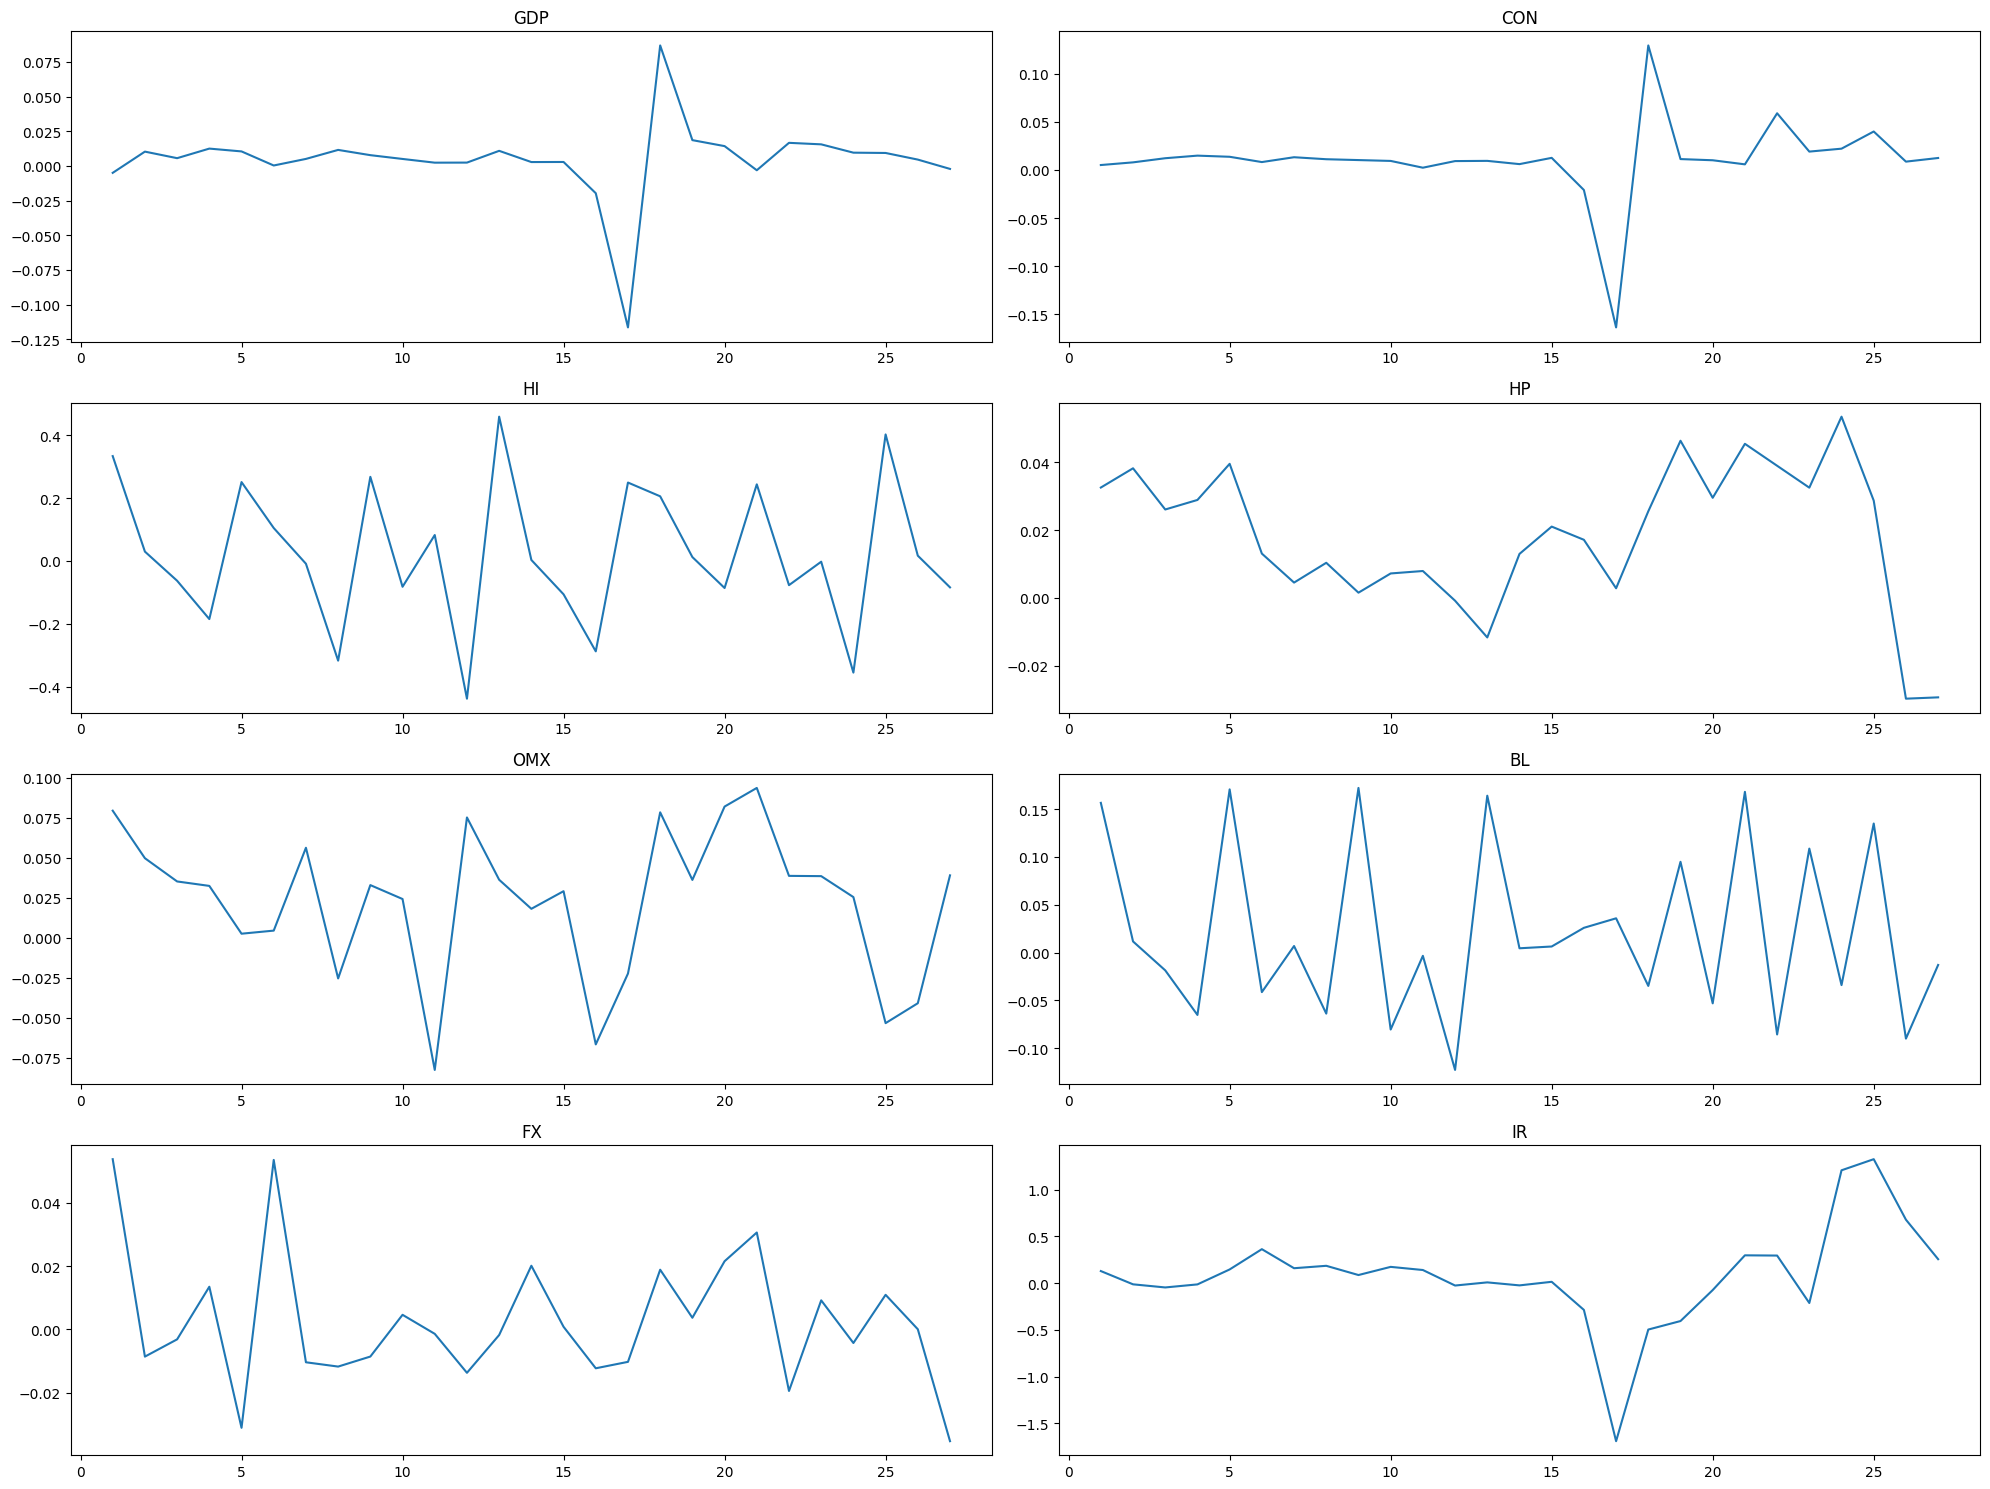

In [70]:
# List of columns to plot LOG DIFFERENCE
columns = ['GDP', 'CON', 'HI', 'HP', 'OMX', 'BL', 'FX', 'IR']

# Create a 4x2 grid of subplots
fig, axs = plt.subplots(4, 2, figsize=(20, 15))

# Flatten the axes array
axs = axs.flatten()

# Plot each column
for i, col in enumerate(columns):
    axs[i].plot(final_df[col])
    axs[i].set_title(col)

# Show the plot
plt.tight_layout()
plt.show()

| Variable   |   ADF Statistic | ADF p-value               |   KPSS Statistic | KPSS p-value          |   PP Statistic | PP p-value                |
|:-----------|----------------:|:--------------------------|-----------------:|:----------------------|---------------:|:--------------------------|
| GDP        |        -6.30393 | 3.3594253329967654e-08*** |        0.118542  | 0.1                   |       -7.93855 | 3.3619417972843434e-12*** |
| CON        |        -6.66152 | 4.833733267242819e-09***  |        0.153384  | 0.1                   |       -7.30729 | 1.291504240330589e-10***  |
| HI         |        -1.31928 | 0.6203054745258789        |        0.5       | 0.04166666666666681** |      -12.8859  | 4.5553916453747404e-24*** |
| HP         |        -1.33169 | 0.6145525891658351        |        0.105578  | 0.1                   |       -1.33844 | 0.6114097839362378        |
| OMX        |        -3.85771 | 0.002369055416369144***   |        0.0934562 | 0.1                   |   

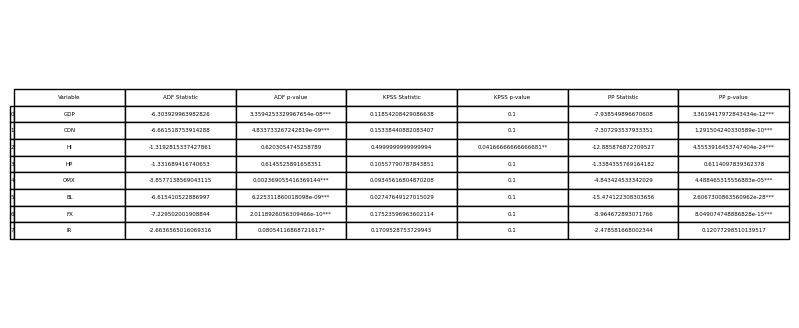

In [71]:
from statsmodels.tsa.stattools import adfuller, kpss
from arch.unitroot import PhillipsPerron
def significance_marker(p_value):
    if p_value < 0.01:
        return '***'
    elif p_value < 0.05:
        return '**'
    elif p_value < 0.1:
        return '*'
    else:
        return ''

results_df = pd.DataFrame()

# Your existing code follows
for col in columns:
    adf_result = adfuller(final_df[col].dropna())
    kpss_result = kpss(final_df[col].dropna())
    pp_test = PhillipsPerron(final_df[col].dropna())
    
    new_row = pd.DataFrame({
        'Variable': [col], 
        'ADF Statistic': [adf_result[0]], 
        'ADF p-value': [str(adf_result[1]) + significance_marker(adf_result[1])],
        'KPSS Statistic': [kpss_result[0]], 
        'KPSS p-value': [str(kpss_result[1]) + significance_marker(kpss_result[1])],
        'PP Statistic': [pp_test.stat], 
        'PP p-value': [str(pp_test.pvalue) + significance_marker(pp_test.pvalue)]
    })

    results_df = pd.concat([results_df, new_row], ignore_index=True)

# Print the results as a markdown table
print(results_df.to_markdown(index=False))

import matplotlib.pyplot as plt
from pandas.plotting import table

# Create a new figure
fig, ax = plt.subplots(figsize=(10, 4)) # set size frame
ax.axis('off')  # hide the axes

# Create a table and add it to the figure
tbl = table(ax, results_df, loc='center', cellLoc='center')

# Save the figure as a jpeg
fig.savefig('table.jpeg')

In [72]:
# Convert DataFrame to NumPy array
endog_data = final_df[['GDP', 'CON', 'HI', 'HP', 'OMX', 'BL', 'FX', 'IR']].to_numpy()

# Impose Short-Term Restrictions for SVAR
B_matrix = np.array([
    [1, 'E', 'E', 0, 0, 0, 0, 0],
    [0, 1, 0, 'E', 'E', 'E', 0, 'E'],
    [0, 0, 1, 'E', 0,'E', 0, 'E'],
    [0, 0, 0, 1, 'E', 'E', 0, 'E'],
    [0, 0, 0, 0, 1, 'E', 'E', 'E'],
    [0, 0, 0, 0, 0, 1, 'E', 'E'],
    [0, 0, 0, 0, 0, 0, 1, 'E'],
    [0, 0, 0, 0, 0, 0, 0, 1],
])


# Define SVAR Model
svar_model = SVAR(endog=endog_data, svar_type='B', A=None, B=B_matrix, dates=final_df['Quarters'])

result = svar_model.fit()

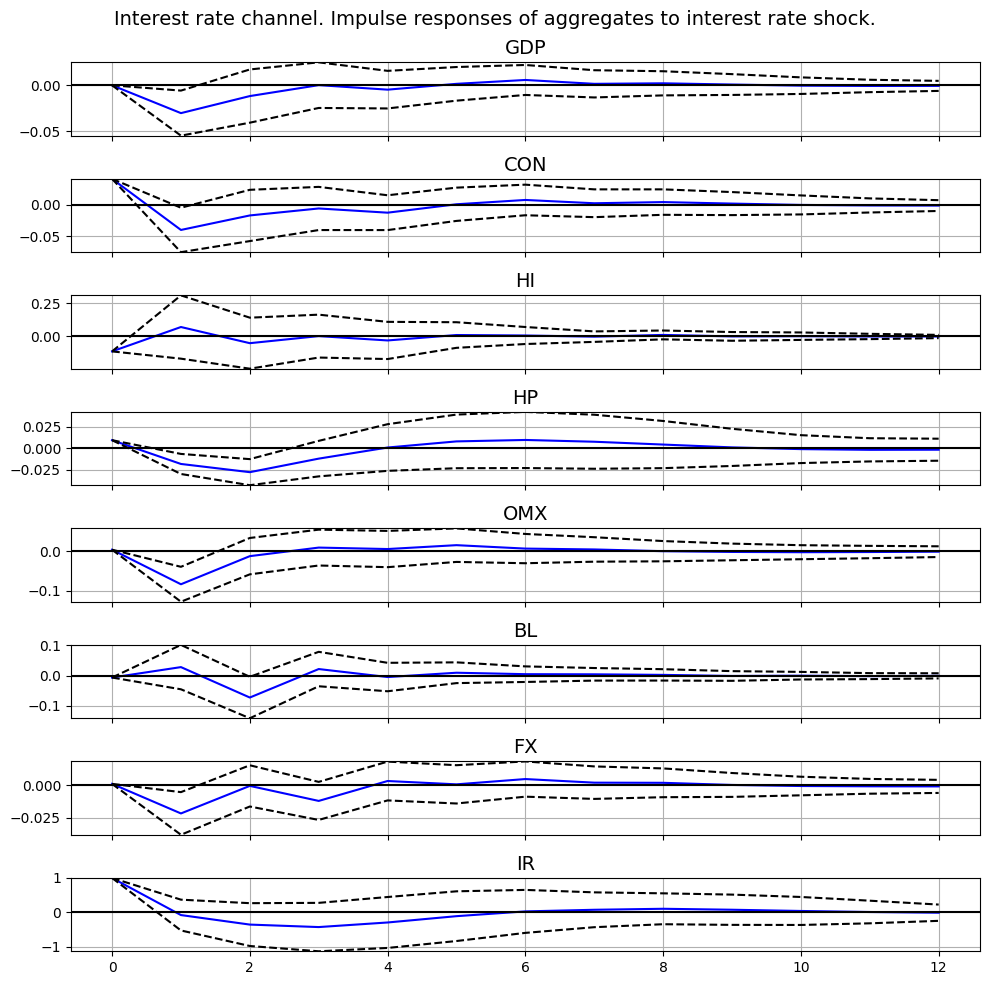

In [73]:
# Get the list of variable names in the model
var_names = ['GDP', 'CON', 'HI', 'HP', 'OMX', 'BL', 'FX', 'IR']

# Find the index of 't_bills' in this list
impulse_index = var_names.index('IR')

# Use this index for the impulse parameter
irf = result.irf(periods=12)

# Create a figure with multiple subplots
fig = irf.plot(impulse=impulse_index, plot_stderr=True, subplot_params={'figsize': (10, 20)})

# Loop over the axes and set the title
for i, ax in enumerate(fig.axes):
    ax.set_title(f'{var_names[i]}', fontsize=14)
    ax.grid(True)
    ax.autoscale(enable=True, axis='y', tight=True)  # Automatically adjust y-axis limits

# Set the overall title
fig.suptitle('Interest rate channel. Impulse responses of aggregates to interest rate shock.', fontsize=14)

plt.tight_layout()
plt.show()

In [74]:
# Get the impulse responses for all periods
irfs = irf.irfs

# Convert the array into a DataFrame
df = pd.DataFrame(irfs[:, impulse_index, :], columns=var_names)

# Set the index to be the periods
df.index.name = 'Period'

# Display the DataFrame with a title
print("Interest rate channel. Impulse responses of aggregates to interest rate shock.")
display(df)

Interest rate channel. Impulse responses of aggregates to interest rate shock.


,GDP,CON,HI,HP,OMX,BL,FX,IR
Period,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
1,27.355417,-23.461285,0.903856,7.012087,4.169568,-1.590351,-3.141369,0.906599
2,23.979372,-16.314804,0.213774,6.383000,2.069942,-0.318447,2.287419,0.270125
3,11.320553,-7.196974,0.659103,6.651280,1.996245,-1.295471,-1.225439,-0.134425
4,-0.417487,0.383788,0.211554,3.785595,0.475482,-0.427431,1.468534,-0.331032
5,-6.372351,5.368677,-0.142541,1.181925,-0.661647,0.327729,0.732054,-0.359683
6,-8.536408,6.551390,-0.180145,-0.680059,-0.694085,0.242489,0.482525,-0.256667
7,-6.393792,4.588355,-0.152830,-1.402305,-0.745954,0.313659,0.221976,-0.117347
8,-3.738699,2.648622,-0.157277,-1.489079,-0.492044,0.279850,-0.005271,-0.008406


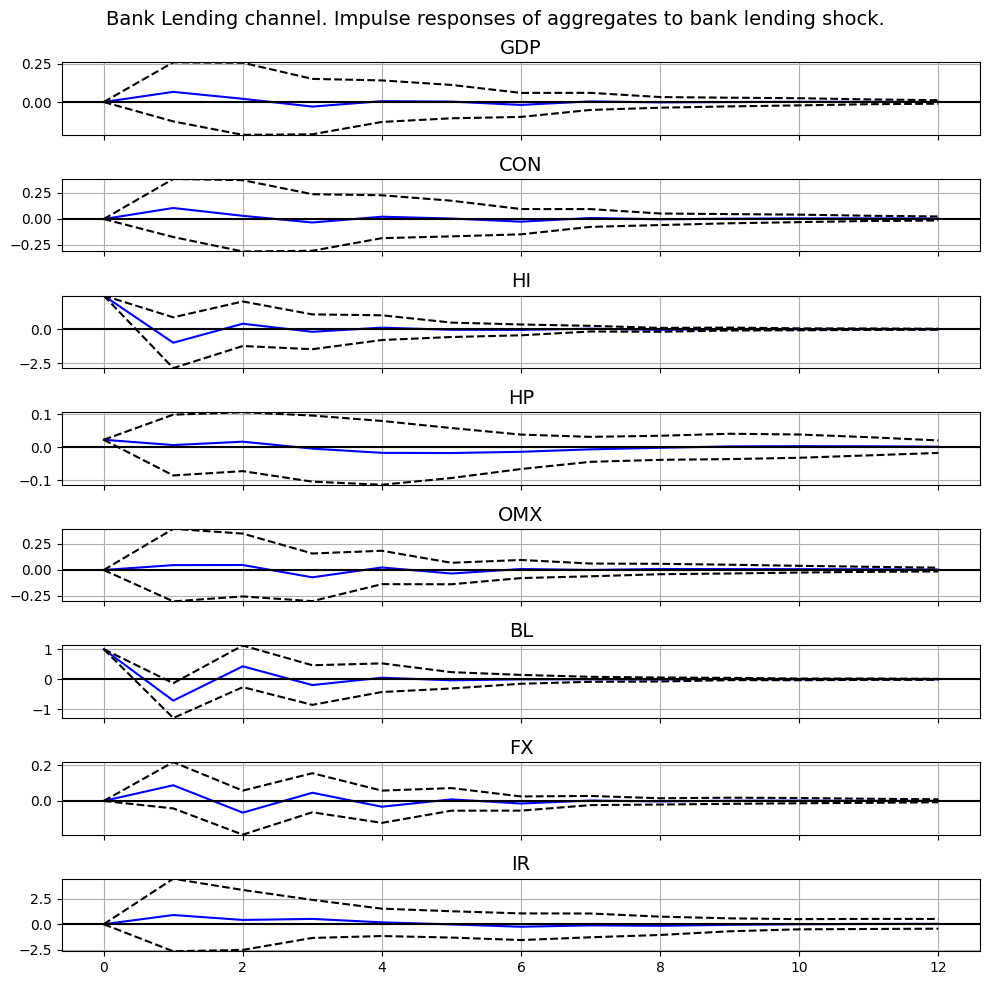

In [75]:
# Get the list of variable names in the model
var_names = ['GDP', 'CON', 'HI', 'HP', 'OMX', 'BL', 'FX', 'IR']

# Find the index of 't_bills' in this list
impulse_index = var_names.index('BL')

# Use this index for the impulse parameter
irf = result.irf(periods=12)

# Create a figure with multiple subplots
fig = irf.plot(impulse=impulse_index, plot_stderr=True, subplot_params={'figsize': (10, 20)})

# Loop over the axes and set the title
for i, ax in enumerate(fig.axes):
    ax.set_title(f'{var_names[i]}', fontsize=14)
    ax.grid(True)
    ax.autoscale(enable=True, axis='y', tight=True)  # Automatically adjust y-axis limits

# Set the overall title
fig.suptitle('Bank Lending channel. Impulse responses of aggregates to bank lending shock.', fontsize=14)

plt.tight_layout()
plt.show()

In [76]:
# Get the impulse responses for all periods
irfs = irf.irfs

# Convert the array into a DataFrame
df = pd.DataFrame(irfs[:, impulse_index, :], columns=var_names)

# Set the index to be the periods
df.index.name = 'Period'

# Display the DataFrame with a title
print("Bank Lending channel. Impulse responses of aggregates to interest rate shock.")
display(df)

Bank Lending channel. Impulse responses of aggregates to interest rate shock.


,GDP,CON,HI,HP,OMX,BL,FX,IR
Period,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
1,-0.193345,0.348474,-0.162072,0.101075,0.453116,-0.302249,0.262383,-0.009713
2,1.130664,-0.735402,0.175083,0.258296,-0.211326,-0.014004,0.018227,-0.024011
3,-1.199586,0.734993,-0.066643,0.085785,0.117559,-0.023688,-0.163515,-0.017627
4,-0.235909,0.303549,-0.015645,-0.183416,-0.179254,0.097237,0.325866,-0.016578
5,-0.458151,0.300954,0.001201,-0.027109,0.030694,-0.034186,-0.254947,-0.002713
6,-0.139960,0.074418,-0.011300,-0.130065,-0.048939,0.030757,0.162316,0.001663
7,0.027403,-0.009599,-0.002306,-0.030349,-0.005168,0.006876,-0.099368,0.004793
8,0.060831,-0.057259,0.000454,-0.029836,0.013359,-0.007177,0.028506,0.004895


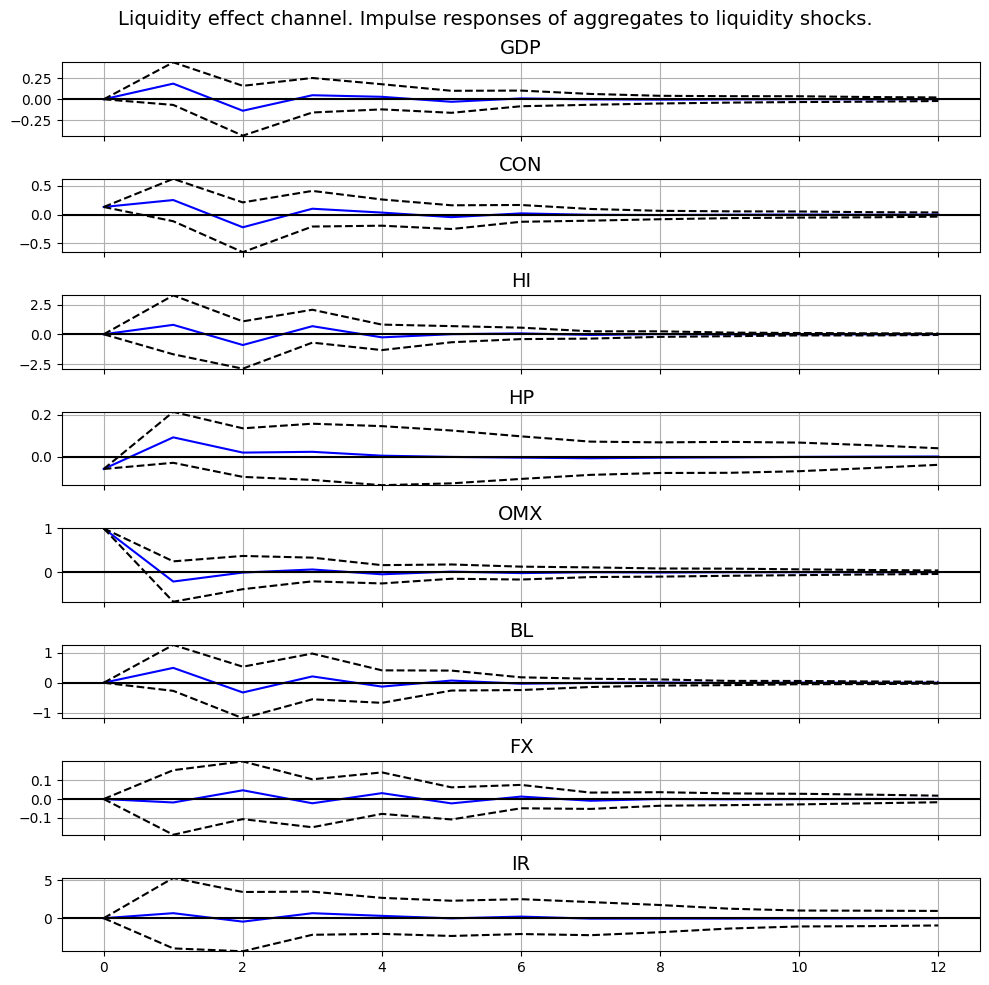

In [77]:
# Get the list of variable names in the model
var_names = ['GDP', 'CON', 'HI', 'HP', 'OMX', 'BL', 'FX', 'IR']

# Find the index of 't_bills' in this list
impulse_index = var_names.index('OMX')

# Use this index for the impulse parameter
irf = result.irf(periods=12)

# Create a figure with multiple subplots
fig = irf.plot(impulse=impulse_index, plot_stderr=True, subplot_params={'figsize': (10, 20)})

# Loop over the axes and set the title
for i, ax in enumerate(fig.axes):
    ax.set_title(f'{var_names[i]}', fontsize=14)
    ax.grid(True)
    ax.autoscale(enable=True, axis='y', tight=True)  # Automatically adjust y-axis limits

# Set the overall title
fig.suptitle('Liquidity effect channel. Impulse responses of aggregates to liquidity shocks.', fontsize=14)

plt.tight_layout()
plt.show()

In [78]:
# Get the impulse responses for all periods
irfs = irf.irfs

# Convert the array into a DataFrame
df = pd.DataFrame(irfs[:, impulse_index, :], columns=var_names)

# Set the index to be the periods
df.index.name = 'Period'

# Display the DataFrame with a title
print("Liquidity Effect channel. Impulse responses of aggregates to interest rate shock.")
display(df)

Liquidity Effect channel. Impulse responses of aggregates to interest rate shock.


,GDP,CON,HI,HP,OMX,BL,FX,IR
Period,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
1,1.702421,-1.252470,0.085563,0.387037,-0.022932,-0.184296,0.410419,-0.027425
2,-0.753699,0.681613,-0.008384,0.144999,-0.088116,0.063643,-0.193468,-0.042118
3,-1.153579,0.846249,-0.031826,-0.159874,-0.057424,0.011293,0.176130,-0.027950
4,-0.592391,0.426545,-0.008957,-0.160008,-0.111420,0.047243,-0.024590,-0.010962
5,-0.463475,0.324926,-0.024453,-0.185662,-0.038493,0.028048,0.002047,0.001130
6,-0.005665,-0.008691,-0.001397,-0.113627,-0.023819,0.011012,-0.014603,0.008073
7,0.130376,-0.115618,0.000240,-0.039551,0.014208,-0.003586,-0.033928,0.009618
8,0.219004,-0.164948,0.003800,0.004281,0.015964,-0.004987,-0.003173,0.007198
